In [1]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Set the style for seaborn
sns.set_theme(style="whitegrid")

# Load Data

In [2]:
matches = pd.read_csv("vct_data/test_preprocessed.csv")

features = [
    "Team A_Encoded", 
    "Team B_Encoded",

    "Team A H2H Win %",
    "Team B H2H Win %",

    "Team A Tournament Win %",
    "Team B Tournament Win %",

    "Recent Win %_TeamA",
    "Recent Win %_TeamB",

    "Team A Map Win %",
    "Team B Map Win %",

    "Round Win %_RollAvg_TeamA",
    "Round Win %_RollAvg_TeamB",

    "Attacker Win %_RollAvg_TeamA",
    "Attacker Win %_RollAvg_TeamB",

    "Overtime Win %_RollAvg_TeamA",
    "Overtime Win %_RollAvg_TeamB",

    "KDA_RollAvg_TeamA",
    "KDA_RollAvg_TeamB",

    "First Blood %_RollAvg_TeamA",
    "First Blood %_RollAvg_TeamB",

    "Headshot %_RollAvg_TeamA",
    "Headshot %_RollAvg_TeamB",

    "Clutches_RollAvg_TeamA",
    "Clutches_RollAvg_TeamB",

    "Econ_RollAvg_TeamA",
    "Econ_RollAvg_TeamB",
]

X_test = matches[features]
y_test = matches["Winner"]

X_test.head()

,Team A_Encoded,Team B_Encoded,Team A H2H Win %,Team B H2H Win %,Team A Tournament Win %,Team B Tournament Win %,Recent Win %_TeamA,Recent Win %_TeamB,Team A Map Win %,Team B Map Win %,Round Win %_RollAvg_TeamA,Round Win %_RollAvg_TeamB,Attacker Win %_RollAvg_TeamA,Attacker Win %_RollAvg_TeamB,Overtime Win %_RollAvg_TeamA,Overtime Win %_RollAvg_TeamB,KDA_RollAvg_TeamA,KDA_RollAvg_TeamB,First Blood %_RollAvg_TeamA,First Blood %_RollAvg_TeamB,Headshot %_RollAvg_TeamA,Headshot %_RollAvg_TeamB,Clutches_RollAvg_TeamA,Clutches_RollAvg_TeamB,Econ_RollAvg_TeamA,Econ_RollAvg_TeamB
0,0.447334,0.414839,0.5,0.5,0.500000,0.571429,0.4,0.6,0.200000,0.666667,0.440863,0.489425,0.450000,0.562500,0.000,0.025,1.301095,1.379461,0.513037,0.475159,0.2098,0.2452,1.6,1.8,50.04,52.34
1,0.572950,0.371567,1.0,0.0,0.533333,0.680000,0.3,0.4,0.666667,0.666667,0.459425,0.524396,0.500000,0.545014,0.025,0.000,1.312059,1.607471,0.460159,0.550017,0.2482,0.2510,1.8,1.4,51.30,57.50
2,0.628433,0.414839,0.0,1.0,0.680000,0.533333,0.6,0.7,0.666667,0.666667,0.524396,0.459425,0.545014,0.500000,0.000,0.025,1.607471,1.312059,0.550017,0.460159,0.2510,0.2482,1.4,1.8,57.50,51.30
3,0.572950,0.371567,0.5,0.5,0.500000,0.692308,0.3,0.4,0.600000,0.700000,0.486508,0.497312,0.491667,0.520014,0.025,0.000,1.367839,1.434472,0.472659,0.531267,0.2430,0.2582,1.9,1.4,52.70,54.70
4,0.628433,0.414839,0.5,0.5,0.692308,0.500000,0.6,0.7,0.700000,0.600000,0.497312,0.486508,0.520014,0.491667,0.000,0.025,1.434472,1.367839,0.531267,0.472659,0.2582,0.2430,1.4,1.9,54.70,52.70


# Load Pretrained Model

In [3]:
model = joblib.load("models/rf_optuna.pkl")
print(model)

RandomForestClassifier(max_depth=33, max_features='log2', min_samples_leaf=10,
                       min_samples_split=3, n_estimators=816, n_jobs=-1,
                       random_state=1)


# Defining Betting Strategies

In [4]:
class BettingStrategy:
    def __init__(self, initial_bankroll):
        self.bankroll = initial_bankroll
        self.bets = []
        self.profits = []

    def place_bet(self, prob, odds, actual_outcome):
        stake = self.get_stake(prob, odds)
        if stake > 0:
            self.bets.append(stake)
            if actual_outcome:
                profit = stake * (odds - 1)
                self.bankroll += profit
                self.profits.append(profit)
            else:
                self.bankroll -= stake
                self.profits.append(-stake)
        else:
            self.bets.append(0)
            self.profits.append(0)
        return self.bankroll

    def get_stake(self, prob, odds):
        raise NotImplementedError


# Fixed percentage of the bankroll is wagered on every bet
class FlatBetting(BettingStrategy):
    def __init__(self, initial_bankroll, stake_percentage=0.01):
        super().__init__(initial_bankroll)
        self.stake_percentage = stake_percentage

    def get_stake(self, prob, odds):
        return min(self.bankroll * self.stake_percentage, self.bankroll * 0.1)


# Designed to maximize long-term wealth by adjusting the bet size based on the perceived edge
# Kelly Criterion formula is used to determine the optimal fraction of the bankroll to wager
class KellyBetting(BettingStrategy):
    def __init__(self, initial_bankroll, fraction=0.1):
        super().__init__(initial_bankroll)
        self.fraction = fraction

    def get_stake(self, prob, odds):
        q = 1 - prob
        f = (prob * (odds - 1) - q) / (odds - 1)
        return max(0, min(f * self.fraction * self.bankroll, self.bankroll * 0.1))


# This strategy places a bet only when the probability exceeds a predefined threshold
class ThresholdBetting(BettingStrategy):
    def __init__(self, initial_bankroll, threshold=0.7, stake_percentage=0.02):
        super().__init__(initial_bankroll)
        self.threshold = threshold
        self.stake_percentage = stake_percentage

    def get_stake(self, prob, odds):
        if prob > self.threshold:
            return min(self.bankroll * self.stake_percentage * (prob - self.threshold), self.bankroll * 0.1)
        return 0


# This strategy uses the Fibonacci sequence to determine bet size
# It increases the bet after a loss according to the next number in the Fibonacci sequence.
class FibonacciBetting(BettingStrategy):
    def __init__(self, initial_bankroll, base_stake=1, max_sequence=8):
        super().__init__(initial_bankroll)
        self.base_stake = base_stake
        self.fibonacci_sequence = [1, 1]
        self.current_fibonacci_index = 0
        self.max_sequence = max_sequence

    def get_stake(self, prob, odds):
        stake = self.base_stake * self.fibonacci_sequence[self.current_fibonacci_index]
        return min(stake, self.bankroll * 0.05)  # Limit to 5% of bankroll for safety

    def place_bet(self, prob, odds, actual_outcome):
        result = super().place_bet(prob, odds, actual_outcome)
        if actual_outcome:
            self.current_fibonacci_index = 0
        else:
            self.current_fibonacci_index = min(self.current_fibonacci_index + 1, self.max_sequence - 1)
            if self.current_fibonacci_index >= len(self.fibonacci_sequence):
                self.fibonacci_sequence.append(self.fibonacci_sequence[-1] + self.fibonacci_sequence[-2])
        return result

# Simulating Betting Stragies on Matches

In [5]:
def simulate_betting(model, X_test, y_test, initial_bankroll=10000):
    # Generate predictions and odds
    predicted_probs = model.predict_proba(X_test)
    predicted_prob_TeamA = predicted_probs[:, 1]
    predicted_prob_TeamB = 1 - predicted_prob_TeamA

    vig_percentage = 0.05
    odds_TeamA = 1 / ((1 + vig_percentage) * predicted_prob_TeamA)
    odds_TeamB = 1 / ((1 + vig_percentage) * predicted_prob_TeamB)

    # Initialize strategies
    strategies = {
        'Flat': FlatBetting(initial_bankroll),
        'Kelly': KellyBetting(initial_bankroll),
        'Threshold': ThresholdBetting(initial_bankroll),
        'Fibonacci': FibonacciBetting(initial_bankroll)
    }

    # Simulation loop for each match
    for i in range(len(y_test)):
        prob_A = predicted_prob_TeamA[i]
        prob_B = predicted_prob_TeamB[i]
        odds_A = odds_TeamA[i]
        odds_B = odds_TeamB[i]
        actual_outcome = y_test[i]

        for name, strategy in strategies.items():
            if prob_A > prob_B:
                strategy.place_bet(prob_A, odds_A, actual_outcome == 1)
            else:
                strategy.place_bet(prob_B, odds_B, actual_outcome == 0)

    return strategies


def analyze_results(results):
    for name, strategy in results.items():
        print(f"{name} Strategy:")
        print(f"Final Bankroll: ${strategy.bankroll:.2f}")
        print(f"Total Profit: ${sum(strategy.profits):.2f}")
        print(f"Number of Bets: {len([b for b in strategy.bets if b > 0])}")
        print(f"Win Rate: {sum(p > 0 for p in strategy.profits) / len(strategy.profits):.2%}")
        print(f"ROI: {sum(strategy.profits) / sum(strategy.bets):.2%}")
        print("---")


results = simulate_betting(model, X_test, y_test)
analyze_results(results)

Flat Strategy:
Final Bankroll: $66.23
Total Profit: $-9933.77
Number of Bets: 10121
Win Rate: 61.45%
ROI: -3.84%
---
Kelly Strategy:
Final Bankroll: $7339.05
Total Profit: $-2660.95
Number of Bets: 57
Win Rate: 0.00%
ROI: -5.87%
---
Threshold Strategy:
Final Bankroll: $7958.62
Total Profit: $-2041.38
Number of Bets: 1954
Win Rate: 14.32%
ROI: -6.40%
---
Fibonacci Strategy:
Final Bankroll: $4926.65
Total Profit: $-5073.35
Number of Bets: 10121
Win Rate: 61.45%
ROI: -23.10%
---


# Visualizations

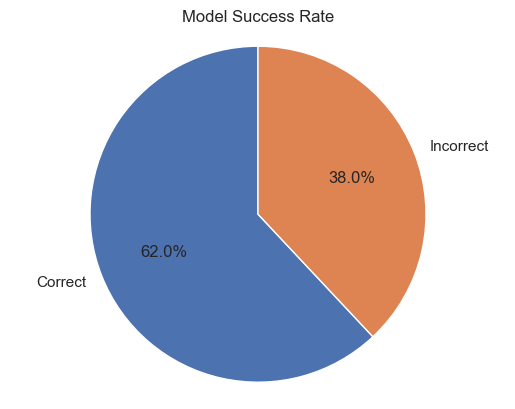

In [6]:
def plot_model_success_rate(y_true, y_pred):
    correct_predictions = np.sum(y_true == np.round(y_pred))
    total_predictions = len(y_true)
    success_rate = correct_predictions / total_predictions
    
    plt.pie([success_rate, 1 - success_rate], labels=['Correct', 'Incorrect'], autopct='%1.1f%%', startangle=90)
    plt.title('Model Success Rate')
    plt.axis('equal')
    plt.show()

plot_model_success_rate(y_test, model.predict(X_test))

The model's success rate of 62% indicates it correctly predicts the outcome of matches more often than random guessing, but there is still a significant portion (38%) of incorrect predictions, which suggests room for improvement in accuracy. This split may indicate challenges with differentiating between teams of similar strength or cases where more granular match dynamics are not fully captured.

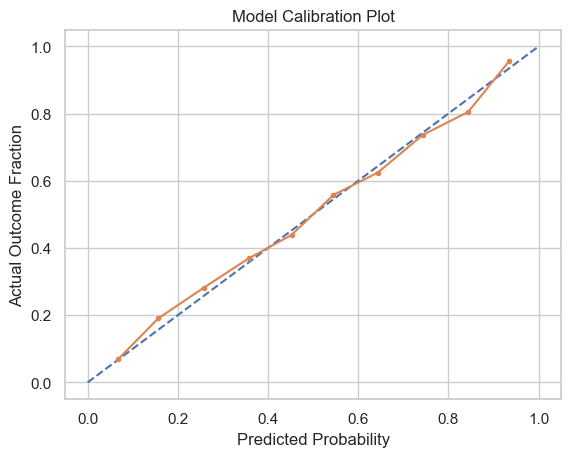

In [7]:
def plot_model_calibration(y_true, y_pred):
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_pred, n_bins=10)
    
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(mean_predicted_value, fraction_of_positives, marker='.')
    
    plt.xlabel('Predicted Probability')
    plt.ylabel('Actual Outcome Fraction')
    plt.title('Model Calibration Plot')
    plt.grid(True)
    plt.show()

plot_model_calibration(y_test, model.predict_proba(X_test)[:, 1])

The model calibration plot shows that the model is well-calibrated. This means that the predicted probabilities align closely with the actual outcomes, indicating that the model's predictions are reliable and can be trusted to represent the true likelihood of events.

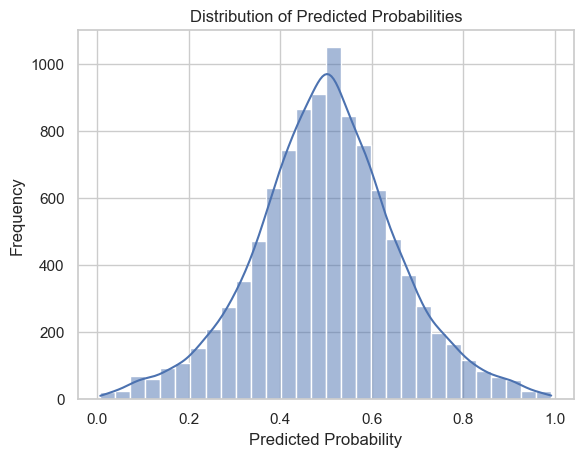

In [8]:
def plot_predicted_probability_distribution(y_pred):
    sns.histplot(y_pred, kde=True, bins=30)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predicted Probabilities')
    plt.show()

plot_predicted_probability_distribution(model.predict_proba(X_test)[:, 1])

The plot shows that the model's predictions are normalized around the center, with the peak slightly above 0.5. This suggests that the model is generally uncertain about most match outcomes, which is common in competitive esports like VALORANT where matches are more susceptible to volatility compared to traditional sports. However, there are a few predictions that are more confident, either leaning heavily towards one team or the other.

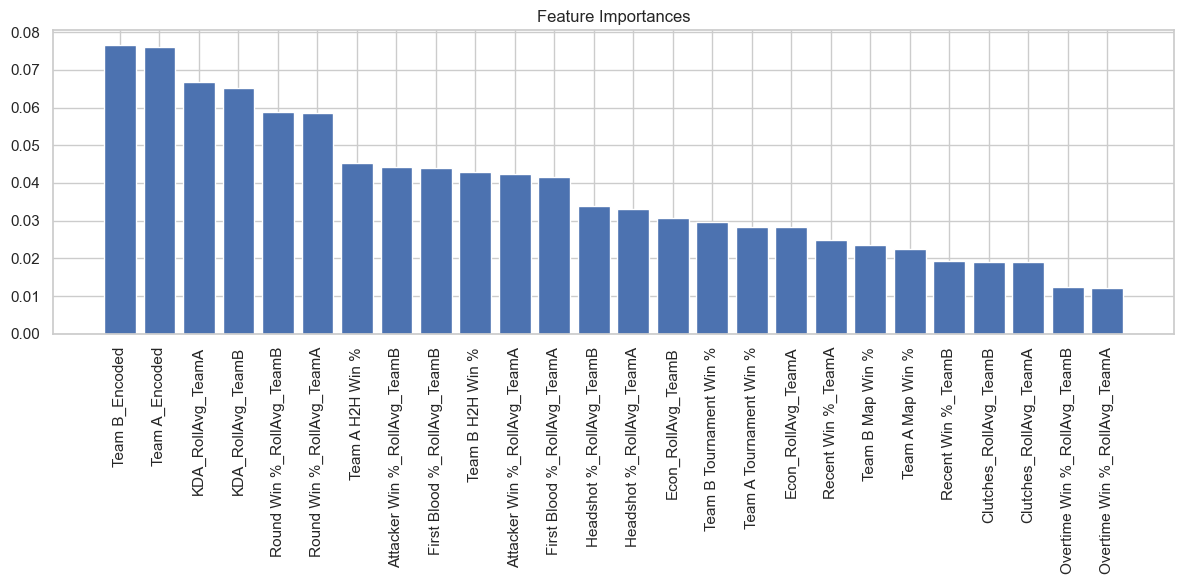

In [9]:
def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

plot_feature_importance(model, features)

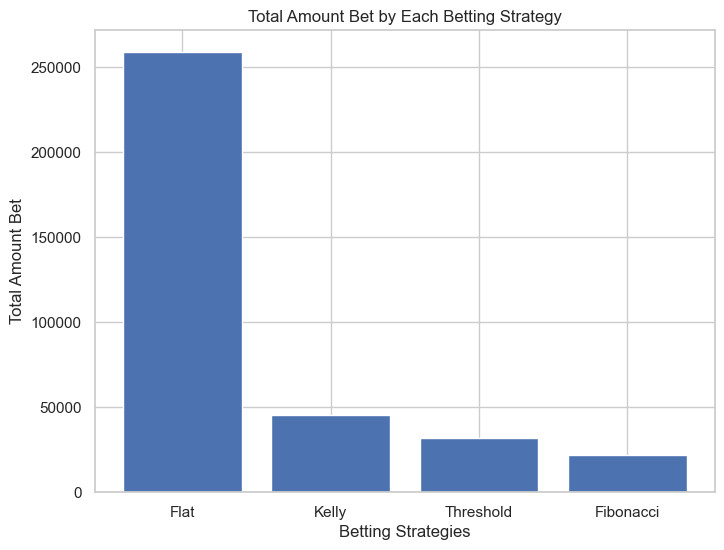

In [13]:
def plot_total_amounts_bet(results):
    strategy_names = list(results.keys())
    total_amounts_bet = [sum(results[strategy].bets) for strategy in strategy_names]
    
    plt.figure(figsize=(8, 6))
    plt.bar(strategy_names, total_amounts_bet)
    plt.xlabel('Betting Strategies')
    plt.ylabel('Total Amount Bet')
    plt.title('Total Amount Bet by Each Betting Strategy')
    plt.show()

plot_total_amounts_bet(results)

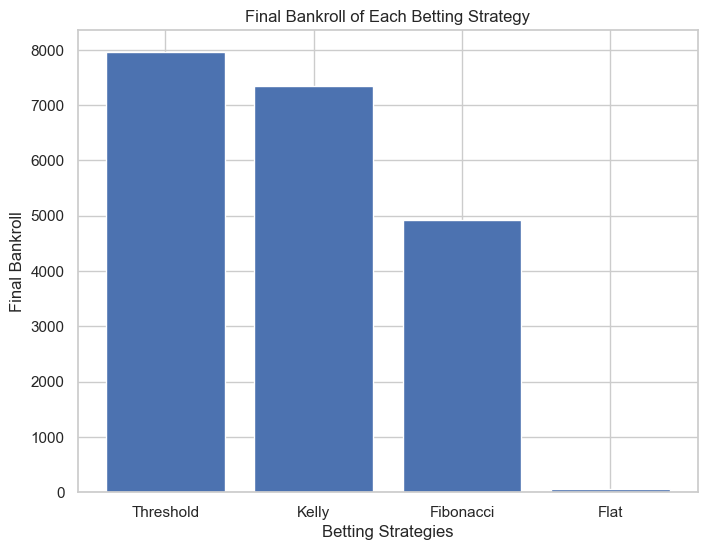

In [11]:
def plot_final_bankroll(results):
    strategy_names = list(results.keys())
    final_bankrolls = [results[strategy].bankroll for strategy in strategy_names]
    
    sorted_data = sorted(zip(strategy_names, final_bankrolls), key=lambda x: x[1], reverse=True)
    sorted_names, sorted_bankrolls = zip(*sorted_data)

    plt.figure(figsize=(8, 6))
    plt.bar(sorted_names, sorted_bankrolls)
    plt.xlabel('Betting Strategies')
    plt.ylabel('Final Bankroll')
    plt.title('Final Bankroll of Each Betting Strategy')
    plt.show()

plot_final_bankroll(results)

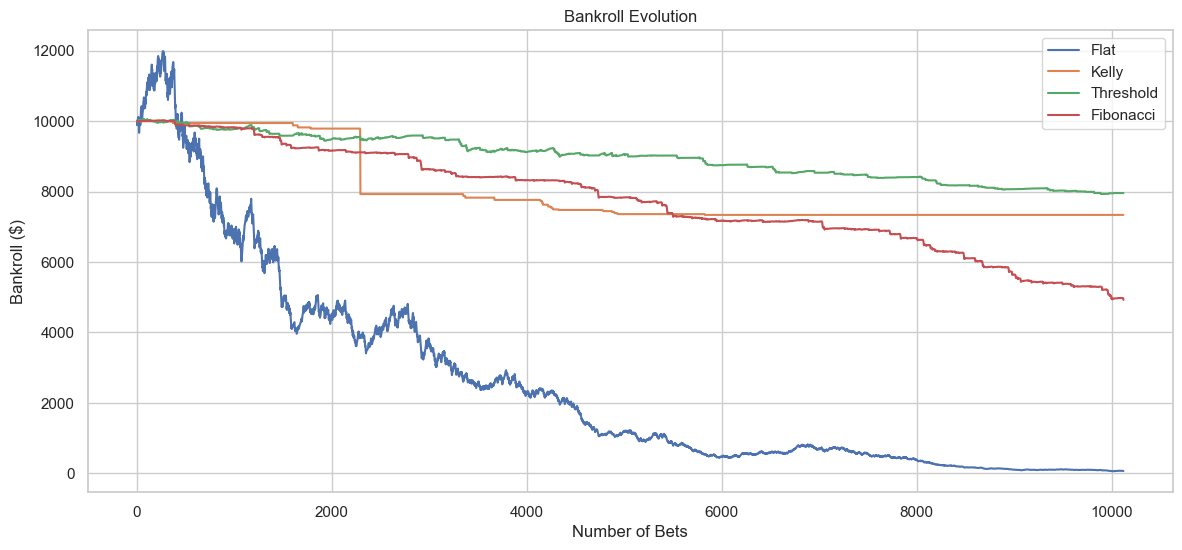

In [12]:
def plot_bankroll_evolution(results):
    plt.figure(figsize=(14, 6))
    for name, strategy in results.items():
        bankroll_history = [10000] + [10000 + sum(strategy.profits[:i+1]) for i in range(len(strategy.profits))]
        plt.plot(bankroll_history, label=name)
    
    plt.xlabel('Number of Bets')
    plt.ylabel('Bankroll ($)')
    plt.title('Bankroll Evolution')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_bankroll_evolution(results)

This plot represents the evolution of a bankroll over time using different betting strategies (Flat, Kelly, Threshold, and Fibonacci) across 10,000 bets. 

- **Flat Betting**: Its line shows a rapid decline in bankroll, indicating that constant bet sizes are particularly risky with this predictive model's accuracy. 

- **Kelly Strategy**: It maintains the bankroll for a while but ultimately shows a slow decline, suggesting that even an adaptive strategy based on calculated risk isn't enough to sustain growth in the long term. 

- **Threshold Betting**: This strategy performs best by preserving the bankroll with less volatility, indicating it may be better suited for minimizing losses by only betting when the model's predicted probability is high.

- **Fibonacci strategy**: Its results in a gradual decrease, indicating it may not be a profitable approach with the given model.


In conclusion, the analysis highlights that higher-risk betting strategies are ineffective, while cautious approaches might better align with the current model's predictions.